# **LE HOANG THINH**
## 19520285



Using pytorch instead of keras to extract features and find the top k images with the nearest topic

Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# Pytorch libs
import torch
import torchvision.models as models
from torchvision import transforms , datasets
from torch import nn

from sklearn.neighbors import KNeighborsClassifier # KNN for finding nearest point
from PIL import Image

# Load pretrained [VGG16 model](https://pytorch.org/vision/master/generated/torchvision.models.vgg16_bn.html)

## Retrive torch device

> On colab, this can run on cuda, otherwise if on pc, need to check the availbility of CUDA



In [2]:
device = torch.device('cuda:0') # "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
vgg16 = models.vgg16_bn(pretrained=True)

## Retrieve the VGG16 classifier with 6 layers

In [4]:
classifier = nn.Sequential(*[vgg16.classifier[i] for i in range(6)])
classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)

In [5]:
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Load data

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

On colab, I have to place 3 folders inside the /images/root folder. Still don't know why

In [7]:
dataset = datasets.ImageFolder('/content/images/root', transform=transform)

# Feature Extraction

Retreive the train test

In [8]:
x_train = []
y_train = []
for x, y in dataset:
  x = vgg16(x.unsqueeze(0).to(device)).squeeze().tolist()
  x_train.append(x)
  y_train.append(y)

Convert to np array

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train,y_train

(array([[-1.43633056,  0.78718394, -0.77086914, ..., -4.53085804,
         -2.04585886,  0.83533239],
        [-2.01205015, -0.56424057, -2.18636847, ..., -5.38042402,
         -0.98526955,  0.4668476 ],
        [-1.54744673,  0.09398516, -0.87229228, ..., -5.06106901,
         -1.00122917,  1.53281426],
        ...,
        [-1.9933759 ,  0.32338426, -1.6752125 , ..., -2.85827518,
         -0.02030192,  1.83695412],
        [-1.80969858,  1.17921138, -3.70618963, ..., -1.35915482,
          1.87208474,  2.20313764],
        [-2.56852722,  0.63731176, -3.16458941, ..., -2.80936289,
          3.10301232,  0.77139574]]), array([0, 0, 0, 1, 1, 1, 2, 2, 2]))

Using KNN with nearest 3 points to find the top 3 images with similar topic. Nghĩa là với mỗi hình ta vẽ được 1 điểm trên đồ thị. Hình càng giống topic, các điểm đó càng gần nhau. Với 3 topic ta sẽ có 3 cụm. Cho 1 tấm hình, ta sẽ vẽ nó trên đồ thị sau đó tìm 3 điểm gần nhất => 3 tấm hình cùng topic nhất

In [10]:
neighborClassifier = KNeighborsClassifier(n_neighbors=3)
neighborClassifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# Testing with a new image

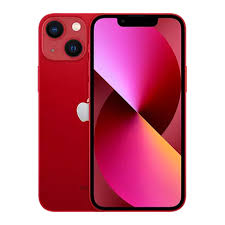

In [11]:
test_img = Image.open('/content/images/root/phone3.jpeg')
test_img

In [12]:
test_img = transform(test_img).unsqueeze(0)
img_feature = vgg16(test_img.to(device)).detach().cpu().numpy()

In [13]:
train_imgs = np.array(dataset.imgs)

Top 3 images with similar topic:


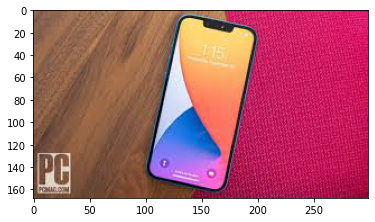

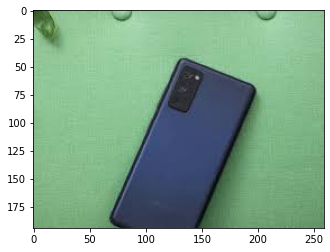

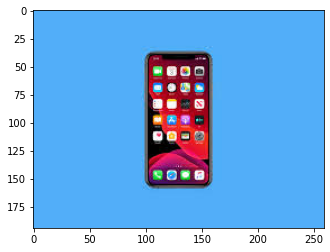

In [14]:
print("Top 3 images with similar topic:")

top_k_nearest_index = neighborClassifier.kneighbors(img_feature, return_distance=False)
top_k_nearest_images = train_imgs[top_k_nearest_index]

for feature_img, label in top_k_nearest_images.squeeze():
  img = Image.open(feature_img)
  plt.imshow(img)
  plt.show()